## 7. QML로 VQE 결과 머신 러닝

VQE 의 결과 데이터를 불러와서 QML을 적용하였습니다.
- 


### 🙏 참고한 자료

In [18]:
import pandas as pd
import numpy as np
from qiskit_machine_learning.algorithms import QSVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.primitives import Sampler, StatevectorSampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute, BaseStateFidelity
from qiskit_machine_learning.kernels import FidelityQuantumKernel

#1. 데이터 전처리
df = pd.read_csv("data/fake-data-set.csv") 
print(df.head())

# molecule을 one-hot 인코딩
encoder = OneHotEncoder(sparse_output=False)
mol_encoded = encoder.fit_transform(df[["molecule"]])
mol_df = pd.DataFrame(mol_encoded, columns=encoder.get_feature_names_out(["molecule"]))

# 입력 특성 X, 출력값 y 구성
X = pd.concat([df[["num_qubits", "gate_count", "circuit_depth"]], mol_df], axis=1)
y = df["energy"]

# 1.1. 샘플 수 제한 (양자 커널은 느림)
X_small = X[:500]
y_small = y[:500]#ravel()
unique, counts = np.unique(y_small, return_counts=True)
print(dict(zip(unique, counts)))

# 1.2. PCA로 차원 축소
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_small)

# 1.3. train/test 분할
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_small, test_size=0.2, random_state=42)

# 2. QSVM 준비
# 2.1. 양자 feature map 설정 (2-qubit ZZFeatureMap)
feature_map = PauliFeatureMap(feature_dimension=4, reps=3)

# 2.2. Quantum kernel 정의
sampler = StatevectorSampler()
fidelity = ComputeUncompute(sampler=sampler)#qiskit1.0 이상부터는 AerSimulator(method="statevector")으로 백엔드를 지정하는 대신에, StatevectorSampler를 샢플러로 쓰면 
quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity = fidelity)

# 3. 학습
# 3.2. SVM 학습 (precomputed kernel 사용)
qsvr = QSVR(quantum_kernel=quantum_kernel)
qsvr.fit(X_train, y_train)

# 4. 학습된 qvsm 으로 X_test 를 분류
y_pred = qsvr.predict(X_test)



     molecule  num_qubits    energy  gate_count  circuit_depth
0  FakeMole_1           8 -1.484695           8              9
1  FakeMole_2           4 -0.566564           2              7
2  FakeMole_3           8 -0.998960           9              6
3  FakeMole_4           8 -0.960623           6              6
4  FakeMole_5           4 -0.816036           7              7
{np.float64(-1.4974049756163534): np.int64(1), np.float64(-1.4972891005856703): np.int64(1), np.float64(-1.4946999936023946): np.int64(1), np.float64(-1.4924656368659253): np.int64(1), np.float64(-1.4877969276819556): np.int64(1), np.float64(-1.4863280351730026): np.int64(1), np.float64(-1.4846954597096151): np.int64(1), np.float64(-1.481757518571639): np.int64(1), np.float64(-1.4778152579696984): np.int64(1), np.float64(-1.4769773952123626): np.int64(1), np.float64(-1.4695278472664055): np.int64(1), np.float64(-1.4681953185148349): np.int64(1), np.float64(-1.4676840488903495): np.int64(1), np.float64(-1.4671533297

In [19]:
# 4. 예측 및 평가
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.1633


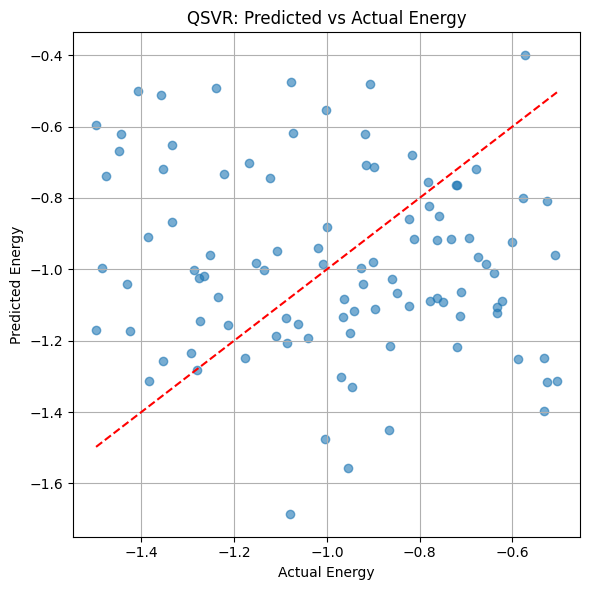

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Energy")
plt.ylabel("Predicted Energy")
plt.title("QSVR: Predicted vs Actual Energy")
plt.grid(True)
plt.tight_layout()
plt.show()


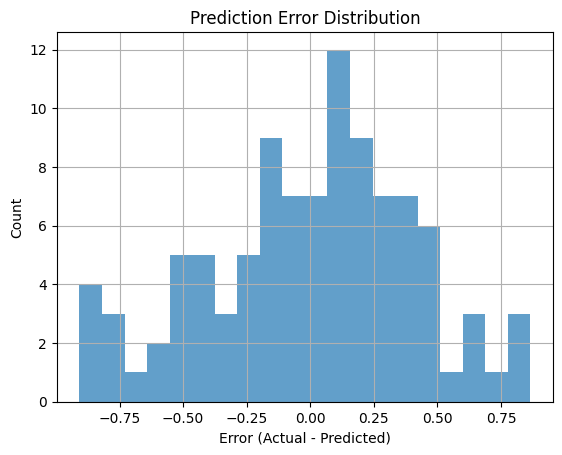

In [21]:
errors = y_test - y_pred
plt.hist(errors, bins=20, alpha=0.7)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [15]:
print("X_train.shape:", X_train.shape)
print("Feature map dimension:", feature_map.feature_dimension)

X_train.shape: (240, 4)
Feature map dimension: 240


In [27]:
def alert(error="error"):
    print("warning!!!", error)
alert()

warning!!! error


## ✍️ 배운 점
- 

## 📌 다음 목표
- 


## 💭궁금한 점 및 추가 정보
#### 1. Sampler vs StatevectorSampler
|Sampler | StatevectorSampler |
| -- | -- |
|- 실제 양자 하드웨어처럼 측정(shots) 결과에서 확률 분포 추정 <br> - 예: $\ket{1}$ 상태가 1024샷 중 300번 나오면, 0.293으로 계산 <br> - 현실에 가까움 (noise 포함 가능) <br> - 실하드웨어 실험 가능| - 회로의 최종 상태벡터를 정확히 알고 있으므로, 확률이 아닌 진짜 내적(fidelity)을 바로 계산 <br>- VQE, 커널 평가에서 빠르고 정확|